In [1]:
import time
from tqdm import tqdm
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, AutoModelForCausalLM
import torch
from qwen_vl_utils import process_vision_info
import cv2
import transformers
import triton
import flash_attn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
model_name = "Qwen/Qwen2.5-VL-7B-Instruct-AWQ"

In [2]:
print(torch.__version__)
print(transformers.__version__)
print(triton.__version__)
print(flash_attn.__version__)

2.3.1+cu121
4.49.0
3.3.0
2.5.9.post1


In [4]:
# # default: Load the model on the available device(s)
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct-AWQ", torch_dtype="auto", device_map="auto"
# )

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct-AWQ",
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

# default processer
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:




# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct-AWQ", min_pixels=min_pixels, max_pixels=max_pixels)
total_pixels=20480 * 28 * 28
min_pixels=16 * 28 * 28
# prompt = """
# Are there people playing soccer with a small white ball? If so, was the ball kicked at the wall during the sequence of frames?
# Please reply with a return format of:
# Soccer ball detected: True [Can be True if small white soccer ball is detected in the scene anywhere, else False]
# Kick detected: False [Can be true only if soccer ball detected is True, and the ball is kicked by player, else False]
# """

prompt = """
You are a referee for a soccer match. Your task is to identify if one of the players has kicked the ball in the air towards the net (which is 
a blue outline on the wall. 
Please reply with a return format of:
Soccer ball detected: True [Can be True if small white soccer ball is detected in the scene anywhere, else False]
Kick detected: False [Can be true only if soccer ball detected is True, and the ball is kicked by player, else False]
"""

messages = [
    {
        "role": "user",
        "content": [
            {
                "video": "file:///workspace/data/soccer_short_goal_clip.mp4",
                "total_pixels": total_pixels,
                "min_pixels": min_pixels,
                "fps": 2,
            },
            {"type": "text", "text": prompt},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True)
fps_inputs = video_kwargs['fps']
print("video fps:", fps_inputs)
print("video input:", video_inputs[0].shape)
num_frames, _, resized_height, resized_width = video_inputs[0].shape
print("num of video tokens:", int(num_frames / 2 * resized_height / 28 * resized_width / 28))
duration_seconds = num_frames / fps_inputs[0]
print(f"⏱️ Video duration after processing: {duration_seconds:.2f} seconds ({num_frames} frames at {fps_inputs[0]} fps)")
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


qwen-vl-utils using decord to read video.


video fps: [1.9024165975279155]
video input: torch.Size([24, 3, 476, 840])
num of video tokens: 6120
⏱️ Video duration after processing: 12.62 seconds (24 frames at 1.9024165975279155 fps)
['Soccer ball detected: True\nKick detected: False']


In [5]:
video_tensor = video_inputs[0]

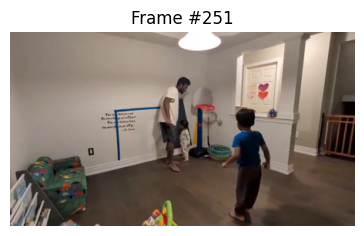

In [6]:
def show_tensor_frame(tensor, frame_idx=0, title="Frame", scale=1.0):
    """
    Display a single frame from a (N, 3, H, W) uint8 tensor.
    """
    frame = tensor[frame_idx].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    frame = frame / 255.0 
    h, w = frame.shape[:2]
    plt.figure(figsize=(w * scale / 100, h * scale / 100))
    plt.imshow(frame)
    plt.title(f"{title} #{frame_idx}")
    plt.axis('off')
    plt.show()

# Example: Display first 10 frames
for i in range(video_tensor.shape[0]):
    clear_output(wait=True)
    show_tensor_frame(video_tensor, frame_idx=i)

torch.float32